# Indicator of heavy rainfall

## Return value approach



In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

from config import DATA_SRC, WEATHER_SRC, POP_DATA_SRC
from util import area_of_pixel

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'

In [4]:
MAX_YEAR = 2019
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

INTERMEDIATE_RESULTS_FOLDER = DATA_SRC / 'lancet' / 'extreme_rain'

RESULTS_FOLDER = Path('./results/extreme rain')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
MAP_PROJECTION = ccrs.EckertIII()

In [6]:
COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/population/country_codes_30min_era_compat.nc'
COUNTRIES_RASTER = xr.open_dataset(COUNTRY_RASTER_FILES).load()

In [7]:
land_mask = (COUNTRIES_RASTER.country_codes < 9999)

## Load event data and apply land mask

In [8]:
events = xr.open_mfdataset(str(INTERMEDIATE_RESULTS_FOLDER / '10_year_events_era5' / '*_events.nc'), 
                           combine='by_coords').where(land_mask)['10year_return_events']
# event_counts = xr.open_mfdataset(str(INTERMEDIATE_RESULTS_FOLDER / '10_year_event_counts_era5' / '*_event_counts.nc'), combine='by_coords').where(land_mask)

## Calculate grid cell areas


In [9]:
# delta_lon = events.longitude[1] - events.longitude[0]
# earth_radius = 6371 #km

# areas = (np.sin(np.radians(events.latitude.values + delta_lon.values/2))
#  - np.sin(np.radians(events.latitude.values - delta_lon.values/2))) * (np.radians(delta_lon.values)) * earth_radius**2

# areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': events.latitude})


In [10]:
areas = area_of_pixel(0.5, events.latitude.values) / (1000*1000)
areas = xr.DataArray(areas, dims=['latitude'], coords={'latitude': events.latitude})

## Calculate time series

In [11]:
event_area_ts = (events * areas).sum(dim=['latitude', 'longitude']).compute()

# Indicators definition

- For this indicator, we care about the area affected in terms of km2 **over land**.
- To summarize over time, we present results per year.
- The more relevant measure per year seems to be the mean of the area affected. Calculate by summing over space the area affected per time step (daily, which is how we defined the heavy rain events), then mean over time to get the average area of the globe affected by heavy rain per year.

Express global trend as 'events' (map) and 'area affected by extreme rain'




# Display the results for 2019/2020

In [12]:
event_area_baseline = event_area_ts.sel(time=slice(f'{REFERENCE_YEAR_START}', f'{REFERENCE_YEAR_END}')).mean()

In [13]:
event_area_yearly = event_area_ts.sel(time=slice('1981',None)).groupby('time.year').mean(dim='time')

In [14]:
event_area_yearly_change = event_area_yearly - event_area_baseline

Show that plotting non-time summarised events is meaningless

[Text(0, 0.5, 'million km2')]

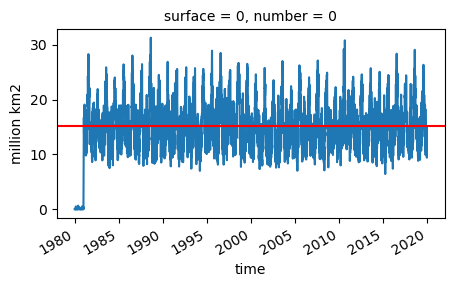

In [15]:
f, ax = plt.subplots()
(event_area_ts / 1_000_000).plot(ax=ax)
ax.axhline(event_area_baseline/ 1_000_000, color='r')
ax.set(ylabel='million km2')

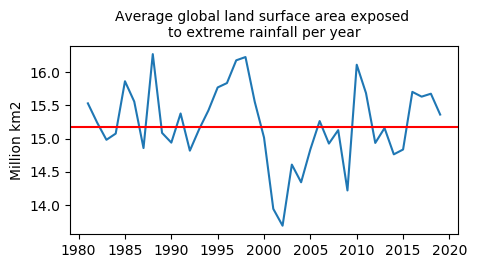

In [50]:
f, ax = plt.subplots()

# Plot ERA5
plot_data = (event_area_yearly/ 1_000_000)
plot_data.plot(ax=ax, label='ERA5')

ax.axhline(event_area_baseline/ 1_000_000, color='r')

ax.set(
    title='Average global land surface area exposed \nto extreme rainfall per year',
    xlabel='',
    ylabel='Million km2'
)

f.show()
f.savefig(RESULTS_FOLDER / 'area_extreme_rainfall_ts.png')

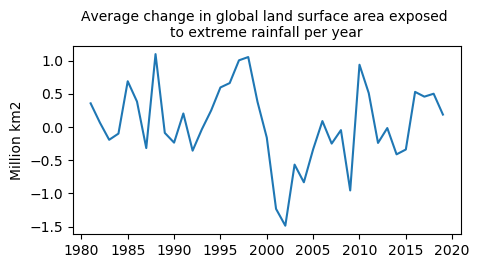

In [51]:
f, ax = plt.subplots()

# Plot ERA5
plot_data = (event_area_yearly_change/ 1_000_000)
plot_data.plot(ax=ax, label='ERA5')

ax.set(
    title='Average change in global land surface area exposed \nto extreme rainfall per year',
    xlabel='',
    ylabel='Million km2'
)

f.show()
# f.savefig(RESULTS_FOLDER / 'area_extreme_rainfall_ts.png')

# Highlight extreme events by summing those where the yearly event count was above the 2SD of the baseline

Following extreme event detetion methods, we plot the trend for events selecting only where the number of events at a given location are greater than mean+2SD (over 95%ile of normal dist) of event counts for that year.

The idea is that the 10 year return period, being essentially based on percentiles, will always give about 35-36 days per year for each location - it's roughly equivalent to counting all events as being in the top 10%ile of the rainfall per day, so the number of events is about 10% of the year. This is clear when we average the number of rainfall days over the whole baseline period - get a solid color map!

Therefore what we want to do is take the events defined as being 'high' rainfall in the baseline period (call these 'normal high') and figure out whether in subsequent years we are seeing more events than even the 'normal high'. 

In [16]:
event_days_per_year = events.groupby('time.year').sum(dim='time').where(land_mask)

In [17]:
event_days_per_year_mean = event_days_per_year.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year').compute()
event_days_per_year_std = event_days_per_year.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).std(dim='year').compute()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [18]:
extreme_event_mask = event_days_per_year > (event_days_per_year_mean + 2*event_days_per_year_std)
events_select_extreme = events.groupby('time.year') * extreme_event_mask

In [20]:
# Save yearly sum thru grid cells (avoid saving every day!) 
# Use for calc by country - sum across cells after
events_select_extreme.groupby('time.year').sum().to_netcdf(INTERMEDIATE_RESULTS_FOLDER / 'excess_extreme_events.nc')

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [21]:
extreme_event_area_ts = (events_select_extreme * areas).sum(dim=['latitude', 'longitude']).compute()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


## Timeseries plots

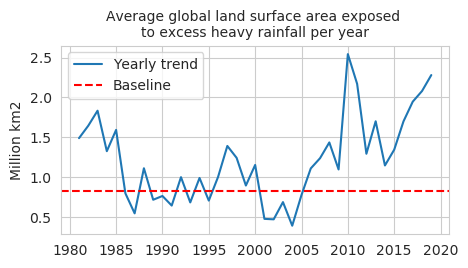

In [37]:
with sns.axes_style('whitegrid'):
    f, ax = plt.subplots()

    # Plot ERA5
    plot_data = (extreme_event_area_ts.sel(time=slice('1981',None)).groupby('time.year').mean(dim='time')/ 1_000_000)

    baseline = (extreme_event_area_ts.sel(time=slice(f'{REFERENCE_YEAR_START}',f'{REFERENCE_YEAR_END}')).mean(dim='time')/ 1_000_000)

    plot_data.plot(ax=ax, label='Yearly trend')

    ax.axhline(baseline, color='r', linestyle='--', label='Baseline')

    ax.legend()
    ax.set(
        title='Average global land surface area exposed \nto excess heavy rainfall per year',
        xlabel='',
        ylabel='Million km2'
    )

    f.savefig(RESULTS_FOLDER / 'area_extreme_rainfall.png')
    plot_data.drop(['number', 'surface']).to_dataframe('area excess heavy rain million km2').to_excel(RESULTS_FOLDER / 'area_excess_heavy_rain.xlsx')
    
    f.show()


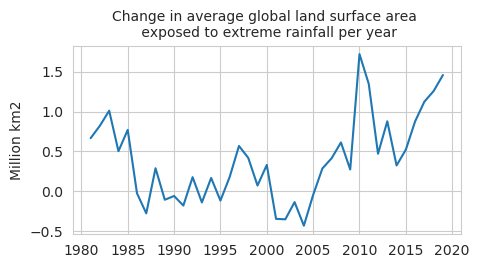

In [38]:
with sns.axes_style('whitegrid'):
    f, ax = plt.subplots()

    # Plot ERA5
    plot_data = (extreme_event_area_ts.sel(time=slice('1981',None)).groupby('time.year').mean(dim='time')/ 1_000_000)

    baseline = (extreme_event_area_ts.sel(time=slice(f'{REFERENCE_YEAR_START}',f'{REFERENCE_YEAR_END}')).mean(dim='time')/ 1_000_000)

    plot_data = plot_data - baseline
    plot_data.plot(ax=ax, label='ERA5')

#     ax.axhline(0, color='k')
    ax.set(
        title='Change in average global land surface area \n exposed to extreme rainfall per year',
        xlabel='',
        ylabel='Million km2'
    )
    f.savefig(RESULTS_FOLDER / 'change_area_extreme_rainfall.png')

    f.show()

### Plot as a percentage of LAND area

In [39]:
# Calculate total earth surface area using same pixel definition
total_earth_area = len(events.longitude) * areas.sum()

In [40]:
total_land_area = (land_mask * areas).sum()

In [41]:
(total_land_area / total_earth_area).item()

0.29872405213122005

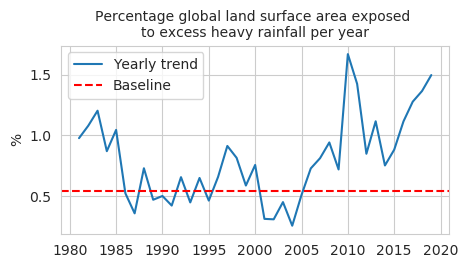

In [43]:
with sns.axes_style('whitegrid'):
    f, ax = plt.subplots()

    # Plot ERA5
    plot_data = (100*extreme_event_area_ts.sel(time=slice('1981',None)).groupby('time.year').mean(dim='time')/ total_land_area)

    baseline = (100*extreme_event_area_ts.sel(time=slice(f'{REFERENCE_YEAR_START}',f'{REFERENCE_YEAR_END}')).mean(dim='time')/ total_land_area)

    plot_data.plot(ax=ax, label='Yearly trend')

    ax.axhline(baseline, color='r', linestyle='--', label='Baseline')

    ax.legend()
    ax.set(
        title='Percentage global land surface area exposed \nto excess heavy rainfall per year',
        xlabel='',
        ylabel='%'
    )

    f.savefig(RESULTS_FOLDER / 'pct_area_extreme_rainfall.png')
    f.savefig(RESULTS_FOLDER / 'pct_area_extreme_rainfall.pdf')

    plot_data.drop(['number', 'surface']).to_dataframe('pct area excess heavy rain').to_excel(RESULTS_FOLDER / 'pct_area_excess_heavy_rain.xlsx')
    plot_data.drop(['number', 'surface']).to_dataframe('pct area excess heavy rain').to_csv(RESULTS_FOLDER / 'pct_area_excess_heavy_rain.csv')
    
    f.show()


### Map plots

In [22]:
def plot_map(plot_data, title=None, robust=False, **plots_kw):
    plots_kw.update(dict(subplot_kw=dict(projection=MAP_PROJECTION)))
    f, ax = plt.subplots(constrained_layout=False, 
                          **plots_kw)

    p = plot_data.plot.pcolormesh(
        transform=ccrs.PlateCarree(),
        cbar_kwargs={'orientation':'horizontal','label':''},
        robust=robust
    )
    p.colorbar.set_label('Extreme rainfall days')

    ax.coastlines()

    ax.set(title=title)

    f.show()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


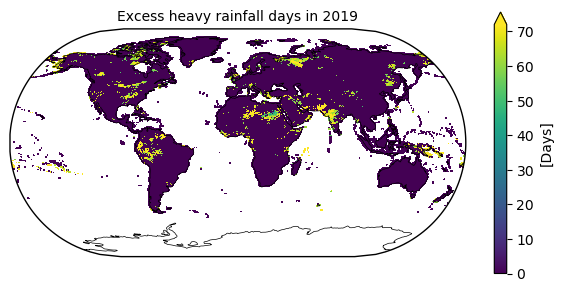

In [39]:
plot_data = (events_select_extreme.groupby('time.year').sum()).sel(year=MAX_YEAR)
plot_data = plot_data.where(land_mask)
# plot_data = plot_data.where(plot_data>0)

f, ax = plt.subplots(figsize=(6,3),
                      subplot_kw=dict(projection=MAP_PROJECTION)
                )

p = plot_data.plot.pcolormesh(
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
#         'orientation':'horizontal',
    'label':'[Days]'},
    robust=True
)
# p.colorbar.set_label('[Days]')

ax.coastlines(linewidth=0.5)
plt.tight_layout()

ax.set(title=f'''Excess heavy rainfall days in {MAX_YEAR}''')

f.savefig(RESULTS_FOLDER/f'map_heavy_rain_{MAX_YEAR}.png')
f.savefig(RESULTS_FOLDER/f'map_heavy_rain_{MAX_YEAR}.pdf')

f.show()

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


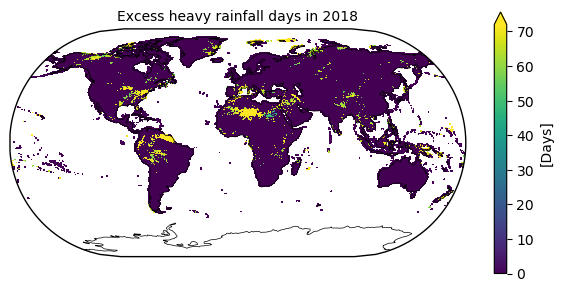

In [40]:
plot_data = (events_select_extreme.groupby('time.year').sum()).sel(year=2018)
plot_data = plot_data.where(land_mask)
# plot_data = plot_data.where(plot_data>0)

f, ax = plt.subplots(figsize=(6,3),
                      subplot_kw=dict(projection=MAP_PROJECTION)
                )

p = plot_data.plot.pcolormesh(
    transform=ccrs.PlateCarree(),
    cbar_kwargs={
#         'orientation':'horizontal',
    'label':'[Days]'},
    robust=True
)
# p.colorbar.set_label('[Days]')

ax.coastlines(linewidth=0.5)
plt.tight_layout()

ax.set(title=f'''Excess heavy rainfall days in 2018''')

# f.savefig(RESULTS_FOLDER/f'map_heavy_rain_{MAX_YEAR}.png')
# f.savefig(RESULTS_FOLDER/f'map_heavy_rain_{MAX_YEAR}.pdf')

f.show()

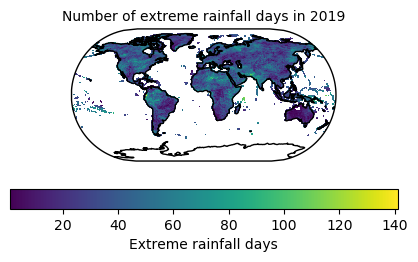

In [61]:
plot_data = event_days_per_year.sel(year=MAX_YEAR).compute()
plot_data = plot_data.where(plot_data > 0)

plot_map(plot_data, f'''Number of extreme rainfall days in {MAX_YEAR}''')

In [20]:
# plot_map(event_days_per_year_mean, f'''Mean number of extreme rainfall days {REFERENCE_YEAR_START} - {REFERENCE_YEAR_END}''')

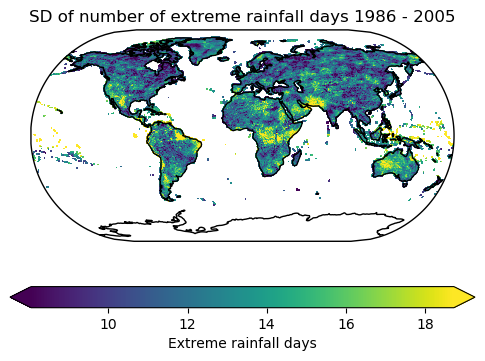

In [98]:
plot_map(event_days_per_year_std, f'''SD of number of extreme rainfall days {REFERENCE_YEAR_START} - {REFERENCE_YEAR_END}''', robust=True)

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


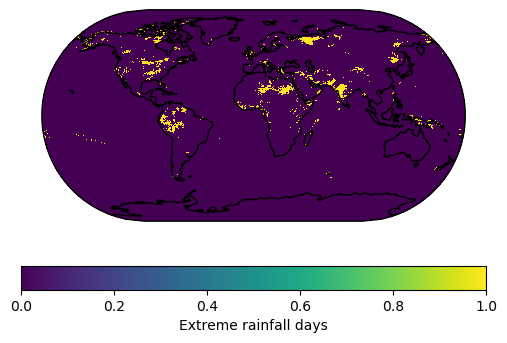

In [99]:
plot_map(extreme_event_mask.isel(year=-1))

In [133]:
import hvplot
import hvplot.xarray

In [141]:
years = [1981, 1990, 1995, 2000,2005,2010,2015,2019]

plot_data = events_select_extreme.groupby('time.year').sum(dim='time').where(land_mask).sel(year=years).compute()
plot_data = plot_data.where(plot_data > 0)

theplot = (plot_data
 .hvplot(
    'longitude', 'latitude', 
    projection=MAP_PROJECTION, coastline=True,
    project=True, global_extent=True, 
    cmap='plasma', 
#     rasterize=True, 
    dynamic=False, 
    frame_width=500,
#     levels=12,
#     clim=(0,12)
))

theplot

/home/jonathanchambers/Scratch/.conda/envs/scienceforge/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


## Compare ERA5 and ERA-Interim old results

> **IMPORTANT FINDING** there seems to be a big difference between them. Perhaps there was some issue in the past years calculation? It seems unlikely because I used almost exactly the same code! Unless the issue was in calculating the accumulations (5.1) - worth double checking. Either way, I'm pretty confident in this year's method and we do seem to be observing a trend (also in the 10 year rolling mean)

### Load ERA-Interim events for comparison

In [38]:
events_eraI = xr.open_mfdataset(str(INTERMEDIATE_RESULTS_FOLDER / 'ppt_ten_year_events_eraI' / '*_events.nc'), 
                                combine='by_coords').where(land_mask)['precipitation_events']
# event_counts_eraI = xr.open_mfdataset(str(INTERMEDIATE_RESULTS_FOLDER / 'ppt_ten_yearly_event_counts' / '*_event_counts.nc'), combine='by_coords').where(land_mask)

In [41]:
event_area_ts_eraI = (events_eraI * areas).sum(dim=['latitude', 'longitude']).compute()

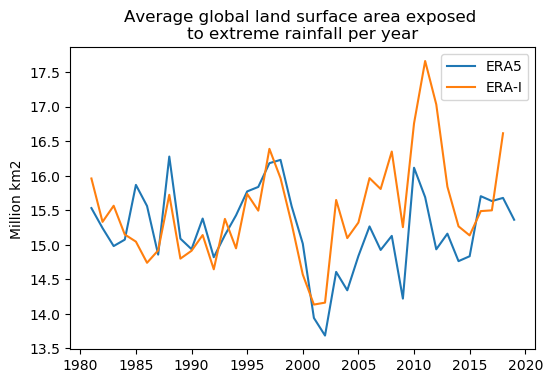

In [42]:
f, ax = plt.subplots()

# Plot ERA5
plot_data = (event_area_ts.sel(time=slice('1981',None)).groupby('time.year').mean(dim='time')/ 1_000_000)
plot_data.plot(ax=ax, label='ERA5')

# Plot ERA Interim
plot_data = (event_area_ts_eraI.sel(time=slice('1981',None)).groupby('time.year').mean(dim='time')/ 1_000_000)
plot_data.plot(ax=ax, label='ERA-I')
ax.legend()

ax.set(
    title='Average global land surface area exposed \nto extreme rainfall per year',
    xlabel='',
    ylabel='Million km2'
)

f.show()
# f.savefig(RESULTS_FOLDER / 'area_extreme_rainfall_ts.png')

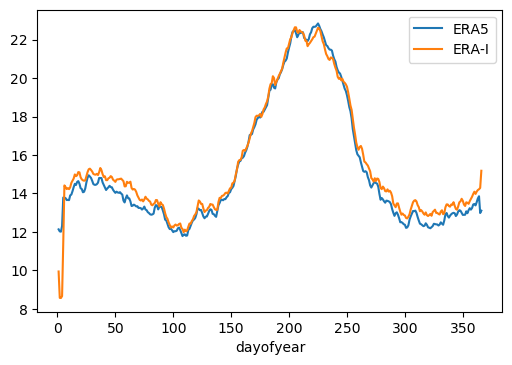

In [65]:
f, ax = plt.subplots()

# Plot ERA5
plot_data = (event_area_ts.sel(time=slice('1981',None)).groupby('time.dayofyear').mean(dim='time')/ 1_000_000)
plot_data.plot(ax=ax, label='ERA5')

# Plot ERA Interim
plot_data = (event_area_ts_eraI.sel(time=slice('1981',None)).groupby('time.dayofyear').mean(dim='time')/ 1_000_000)
plot_data.plot(ax=ax, label='ERA-I')
ax.legend()

# ax.set(
#     title='Average global surface area exposed to extreme rainfall per year',
#     xlabel='',
#     ylabel='Million km2'
# )

f.show()
